# NLP Exploratory Data Analysis (EDA)

This notebook explores the required steps required for a Natural Language Processing (NLP) application. This includes:
- Section 1 - Text Cleaning
    - Spelling Correction
- Section 2 - Preprocessing
    - Sentence Segmentation (not applicable in this case) & Tokenization
    - Stop word removal
    - Stemming & Lemmatization
- Section 3 - Feature Engineering
    - Bag-of-Words
    - Ngram-of-Words
    - Embeddings

**Insights:**
- The dataset is quite balanced (57/43)
- Location require extensive preprocessing. One of the approaches might be dropping those below certain count, as it can be considered polluted records.
- There seem to be a considerable amount of tweets with links

In [18]:
import os
import sys
import pandas as pd
import numpy as np
from tqdm import tqdm

# NLP Preprocessing
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# NLP Viz
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Feature Extraction
from sklearn.feature_extraction.text import CountVectorizer

# Data Modelling
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, recall_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import xgboost
from xgboost import XGBClassifier
xgboost.config_context(verbosity=0) # Silect XGBoost

# Monitoring progress
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

nltk.download('stopwords')

config = {
    'test_size': 0.2,
    'CV_splits': 3,
    'seed': 14,
    'n_cores': 16,
    'max_features': 10000
}

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelcachosoblechero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 0. Load dataset and basic counts

In [19]:
# Load dataset
input_path = "../input"
raw_tweets = pd.read_csv(os.path.join(input_path, "train.csv")).set_index(['id'])
raw_tweets.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
(raw_tweets.target.value_counts() / len(raw_tweets)) * 100.0

0    57.034021
1    42.965979
Name: target, dtype: float64

In [21]:
raw_tweets.location.value_counts()

USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

# 2. Text Preprocessing

Convert the text into a tokenized version by and preprocess it, lowercasing all words, removing stop words and performing stemming and lemmatization.
Lastly, I convert each label to a wordcloud

In [22]:
# Use Twitter Tokenizer to tokenize tweets
tokenizer = TweetTokenizer()

# Tokenize raw tweets
raw_tweets['twitterTokens'] = raw_tweets.apply(lambda x: tokenizer.tokenize(x.text.lower()), axis=1)
raw_tweets.head()

,keyword,location,text,target,twitterTokens
id,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart..."
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]"
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl..."
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al..."


In [23]:
# Remove stop words
english_stopwords = set(stopwords.words('english'))
raw_tweets['twitterTokens_noStop'] = raw_tweets.twitterTokens.apply(lambda x: [i for i in x if i not in english_stopwords])

# Perform stemming
ps = PorterStemmer()
raw_tweets['twitterTokens_Stem'] = raw_tweets.twitterTokens_noStop.apply(lambda x: [ps.stem(i) for i in x])

In [24]:
raw_tweets.head()

,keyword,location,text,target,twitterTokens,twitterTokens_noStop,twitterTokens_Stem
id,,,,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #eart...","[deeds, reason, #earthquake, may, allah, forgi...","[deed, reason, #earthquak, may, allah, forgiv,..."
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, ronge, sask, ., canada]","[forest, fire, near, la, rong, sask, ., canada]"
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl...","[residents, asked, ', shelter, place, ', notif...","[resid, ask, ', shelter, place, ', notifi, off..."
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #wildfires, evacuati...","[13,000, people, receive, #wildfires, evacuati...","[13,000, peopl, receiv, #wildfir, evacu, order..."
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #al...","[got, sent, photo, ruby, #alaska, smoke, #wild...","[got, sent, photo, rubi, #alaska, smoke, #wild..."


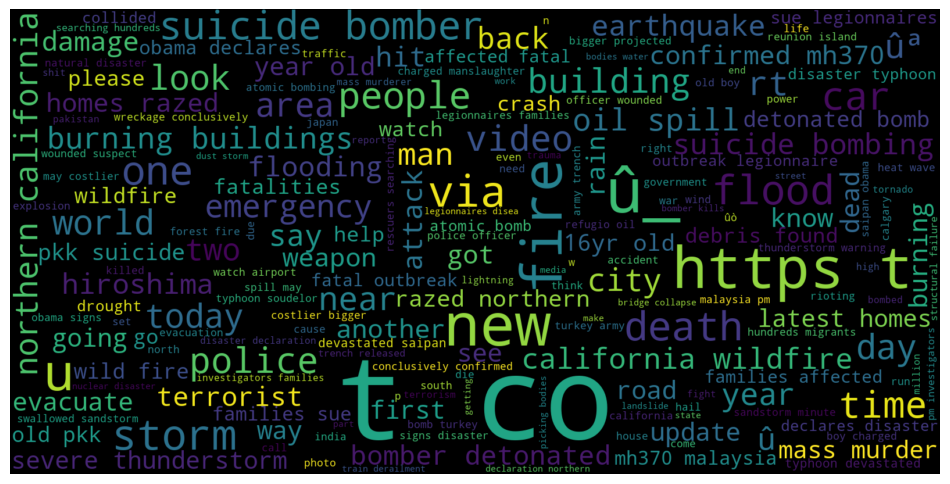

In [25]:
# Extrat the text with real Disaster
disaster_tweets = raw_tweets[raw_tweets.target == 1]
disaster_words = []
for tweet in disaster_tweets.twitterTokens_noStop:
    for word in tweet:
        disaster_words.append(word)
disaster_words = pd.Series(disaster_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(disaster_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


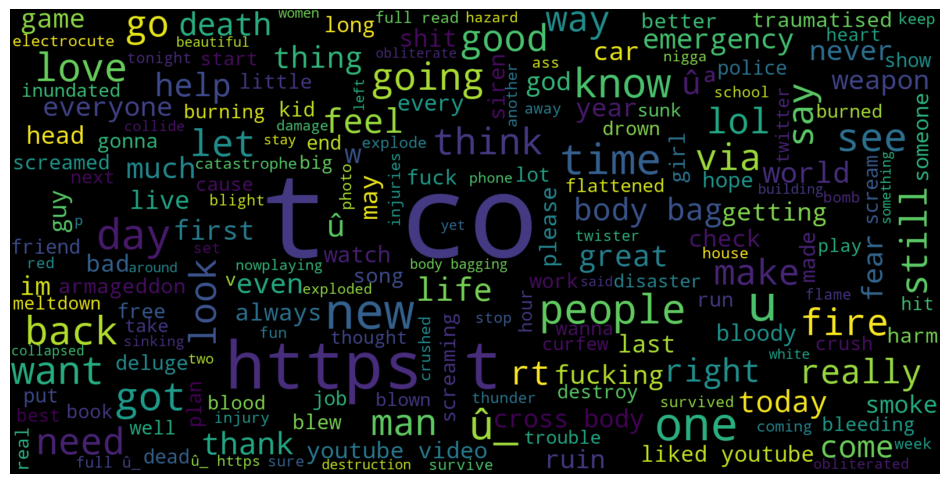

In [26]:
# Extrat the text with no real Disaster
not_disaster_tweets = raw_tweets[raw_tweets.target == 0]
not_disaster_words = []
for tweet in not_disaster_tweets.twitterTokens_noStop:
    for word in tweet:
        not_disaster_words.append(word)
not_disaster_words = pd.Series(not_disaster_words).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(not_disaster_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 3. Feature Engineering
In this section, we will explore multiple approaches:
- Bag-of-Words
- Ngram-of-Words
- Word Embeddings + Average across sentence

In [40]:
X = raw_tweets.drop(['target'], axis=1)
y = raw_tweets.target

In [48]:
# Split between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=config['test_size'], random_state=config['seed'])

In [42]:
# We start by doing this by hand
def vectorize_tweet(tweet, vocab):
    '''
    This function puts 0 if the word is not present in tokens and count of token if present
    :param tweet: Specific tweet
    :param vocab: Seen vocab
    :return: BoW for this tweet
    '''
    vector=[]
    for w in vocab:
        vector.append(tweet.count(w))
    return vector

def get_vocab(all_tweets):
    '''
    This functions returns a list in which the order remains 
    same and no item repeats
    '''
    # Flatten list
    all_tweets_concat = [word for tweet in all_tweets for word in tweet]
    # Extract unique vocabulary
    seen = set()
    return [x for x in all_tweets_concat if not (x in seen or seen.add(x))]

In [43]:
# Extract unique vocabulary
vocab = get_vocab(X_train.twitterTokens_Stem.tolist())

# Vectorize and create a training dataframe for this
X_train = X_train.twitterTokens_Stem.progress_apply(vectorize_tweet, vocab=vocab)
X_train = pd.DataFrame(X_train.tolist(), columns=vocab)

  0%|          | 0/7613 [00:00<?, ?it/s]

In [49]:
# CountVectorizer can be used to perform this action in normal text
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english', max_features=config['max_features'])
X_train = CountVec.fit_transform(X_train.text)

In [50]:
# Create NGrams - TBD
# Generate Embeddings - TBD

# 4. Data Modeling

This section explores different architectures for text classification, ranging from Classic ML to RNN and CNN1D.

## Classic ML Methods

In [51]:
def run_model_and_evaluate(model, X_train, y_train):
    
    # Instanciate a Cross-Validation model
    cv = StratifiedKFold(n_splits=config['CV_splits'])

    # Create empty results
    conf_matrix = np.zeros((2,2))
    accuracy = []
    recall = []
    auc = []

    # For every split    
    for idx_train, idx_test in tqdm(cv.split(X_train, y_train)):
    
        # Obtain the split indeces
        X_cv, y_cv = X_train[idx_train], y_train[idx_train]

        # Train the models 
        model.fit(X_cv, y_cv)

        # Obtain prediction dataset
        X_cv, y_cv = X_train[idx_test], y_train[idx_test]

        # Predict both models
        model_pred = model.predict(X_cv)

        # Store Confusion Matrix + Accuracy Score + Recall Score + AUC
        conf_matrix += confusion_matrix(y_cv, model_pred)
        accuracy.append(accuracy_score(y_cv, model_pred))
        recall.append(recall_score(y_cv, model_pred))
        auc.append(roc_auc_score(y_cv, model_pred))

    return conf_matrix, accuracy, recall, auc

In [52]:
# Define the target models
dummy_model = DummyClassifier()
svc_model = SVC(kernel='linear')
naive_model = MultinomialNB()
rf_model = RandomForestClassifier(n_estimators=20, max_depth=50, random_state=config['seed'], n_jobs = config['n_cores'])
xg_model = XGBClassifier(n_estimators=20, max_depth=50, random_state=config['seed'], n_jobs = config['n_cores'])

# Train all models
print(f"-> Training Dummy")
dummy_conf_matrix, dummy_acc, dummy_recall, dummy_auc = run_model_and_evaluate(dummy_model, X_train, y_train)
print(f"-> Training SVC")
svc_conf_matrix, svc_acc, svc_recall, svc_auc = run_model_and_evaluate(svc_model, X_train, y_train)
print(f"-> Training Multinomial NB")
naive_conf_matrix, naive_acc, naive_recall, naive_auc = run_model_and_evaluate(naive_model, X_train, y_train)
print(f"-> Training Random Forest")
rf_conf_matrix, rf_acc, rf_recall, rf_auc = run_model_and_evaluate(rf_model, X_train, y_train)
print(f"-> Training XGBoost")
xg_conf_matrix, xg_acc, xg_recall, xg_auc = run_model_and_evaluate(xg_model, X_train, y_train)

-> Training Dummy


0it [00:00, ?it/s]


KeyError: '[2011, 2013, 2016, 2018, 2025, 2028, 2030, 2032, 2034, 2044, 2052, 2054, 2057, 2058, 2061, 2062, 2065, 2066, 2072, 2076, 2078, 2079, 2080, 2083, 2084, 2085, 2086, 2088, 2090, 2091, 2092, 2093, 2101, 2102, 2104, 2105, 2106, 2107, 2110, 2118, 2119, 2120, 2121, 2124, 2125, 2127, 2130, 2132, 2135, 2137, 2138, 2140, 2143, 2147, 2148, 2150, 2151, 2152, 2155, 2156, 2162, 2165, 2166, 2167, 2168, 2169, 2170, 2175, 2178, 2180, 2182, 2183, 2184, 2185, 2187, 2193, 2196, 2197, 2198, 2199, 2200, 2201, 2202, 2205, 2206, 2208, 2210, 2211, 2216, 2218, 2223, 2224, 2226, 2228, 2229, 2232, 2234, 2235, 2242, 2243, 2247, 2249, 2250, 2251, 2252, 2253, 2256, 2258, 2259, 2261, 2263, 2264, 2266, 2268, 2269, 2270, 2271, 2276, 2281, 2283, 2287, 2290, 2291, 2293, 2295, 2296, 2298, 2299, 2302, 2305, 2307, 2309, 2310, 2313, 2315, 2316, 2318, 2320, 2322, 2323, 2326, 2327, 2328, 2331, 2332, 2334, 2335, 2338, 2341, 2343, 2344, 2345, 2353, 2354, 2355, 2357, 2358, 2360, 2365, 2369, 2371, 2372, 2375, 2378, 2380, 2381, 2383, 2384, 2390, 2392, 2393, 2399, 2401, 2403, 2404, 2405, 2407, 2411, 2416, 2424, 2426, 2430, 2431, 2433, 2434, 2436, 2437, 2438, 2439, 2441, 2442, 2444, 2447, 2448, 2449, 2450, 2452, 2461, 2469, 2470, 2472, 2473, 2474, 2477, 2480, 2481, 2484, 2490, 2491, 2492, 2495, 2496, 2503, 2506, 2509, 2510, 2511, 2518, 2522, 2525, 2526, 2527, 2529, 2533, 2539, 2543, 2549, 2551, 2556, 2558, 2560, 2562, 2563, 2567, 2569, 2574, 2575, 2576, 2577, 2578, 2580, 2581, 2583, 2584, 2586, 2587, 2588, 2589, 2590, 2595, 2596, 2600, 2601, 2602, 2603, 2604, 2606, 2607, 2609, 2610, 2611, 2612, 2613, 2615, 2618, 2620, 2623, 2626, 2630, 2634, 2636, 2637, 2638, 2639, 2645, 2646, 2650, 2652, 2653, 2654, 2655, 2658, 2659, 2662, 2665, 2668, 2669, 2670, 2674, 2678, 2679, 2680, 2681, 2685, 2686, 2688, 2690, 2691, 2696, 2697, 2699, 2700, 2702, 2704, 2705, 2710, 2712, 2713, 2714, 2716, 2717, 2718, 2719, 2721, 2722, 2729, 2735, 2737, 2738, 2742, 2745, 2746, 2747, 2748, 2750, 2751, 2752, 2753, 2754, 2760, 2762, 2764, 2765, 2768, 2770, 2772, 2775, 2776, 2777, 2779, 2781, 2782, 2788, 2789, 2790, 2791, 2792, 2793, 2795, 2798, 2800, 2804, 2805, 2806, 2807, 2809, 2810, 2812, 2814, 2816, 2818, 2823, 2824, 2834, 2837, 2840, 2842, 2843, 2844, 2845, 2847, 2848, 2850, 2855, 2857, 2859, 2861, 2862, 2863, 2864, 2868, 2870, 2874, 2876, 2882, 2888, 2891, 2892, 2894, 2897, 2901, 2903, 2904, 2906, 2910, 2914, 2918, 2919, 2921, 2923, 2924, 2926, 2928, 2930, 2937, 2938, 2940, 2941, 2943, 2945, 2949, 2951, 2954, 2956, 2958, 2960, 2961, 2962, 2964, 2966, 2967, 2968, 2972, 2974, 2977, 2978, 2979, 2980, 2981, 2985, 2986, 2989, 2994, 2996, 2997, 2999, 3000, 3001, 3002, 3007, 3008, 3017, 3020, 3021, 3022, 3024, 3025, 3028, 3031, 3032, 3033, 3034, 3035, 3036, 3038, 3039, 3040, 3041, 3044, 3046, 3048, 3050, 3051, 3059, 3063, 3065, 3067, 3069, 3076, 3078, 3079, 3080, 3081, 3087, 3088, 3094, 3095, 3096, 3098, 3101, 3103, 3110, 3112, 3113, 3115, 3119, 3120, 3121, 3127, 3128, 3129, 3135, 3141, 3142, 3143, 3146, 3148, 3149, 3151, 3152, 3155, 3156, 3160, 3162, 3164, 3165, 3168, 3169, 3177, 3178, 3182, 3187, 3189, 3194, 3199, 3200, 3201, 3202, 3203, 3204, 3206, 3207, 3208, 3209, 3210, 3213, 3214, 3215, 3216, 3220, 3223, 3224, 3226, 3227, 3228, 3229, 3230, 3232, 3233, 3234, 3238, 3239, 3240, 3242, 3243, 3246, 3247, 3250, 3251, 3254, 3256, 3257, 3258, 3261, 3267, 3268, 3269, 3271, 3272, 3273, 3279, 3284, 3289, 3290, 3291, 3292, 3293, 3294, 3295, 3296, 3298, 3305, 3306, 3307, 3308, 3310, 3313, 3314, 3315, 3316, 3321, 3325, 3326, 3327, 3330, 3331, 3332, 3333, 3334, 3342, 3343, 3344, 3346, 3348, 3349, 3350, 3351, 3352, 3353, 3354, 3355, 3358, 3360, 3362, 3366, 3370, 3371, 3374, 3375, 3377, 3378, 3380, 3382, 3383, 3384, 3385, 3386, 3390, 3392, 3394, 3398, 3399, 3404, 3407, 3409, 3416, 3420, 3421, 3422, 3424, 3425, 3426, 3427, 3433, 3434, 3436, 3438, 3441, 3442, 3443, 3444, 3449, 3453, 3454, 3456, 3457, 3458, 3461, 3467, 3468, 3475, 3478, 3479, 3484, 3485, 3487, 3488, 3491, 3492, 3494, 3495, 3496, 3497, 3499, 3502, 3503, 3504, 3507, 3509, 3511, 3513, 3515, 3516, 3529, 3532, 3538, 3539, 3541, 3543, 3545, 3546, 3547, 3551, 3553, 3556, 3558, 3559, 3561, 3562, 3563, 3564, 3571, 3574, 3576, 3577, 3578, 3579, 3580, 3584, 3586, 3590, 3595, 3596, 3599, 3600, 3601, 3605, 3606, 3609, 3611, 3612, 3614, 3615, 3616, 3617, 3619, 3620, 3622, 3624, 3628, 3630, 3641, 3642, 3644, 3649, 3651, 3654, 3655, 3659, 3660, 3662, 3663, 3665, 3668, 3671, 3672, 3673, 3677, 3678, 3683, 3684, 3687, 3688, 3693, 3698, 3699, 3701, 3703, 3706, 3707, 3708, 3709, 3711, 3713, 3714, 3716, 3718, 3720, 3721, 3722, 3726, 3728, 3729, 3731, 3732, 3733, 3734, 3735, 3737, 3740, 3746, 3748, 3749, 3751, 3755, 3757, 3760, 3762, 3767, 3768, 3769, 3770, 3779, 3781, 3782, 3783, 3784, 3785, 3787, 3790, 3791, 3792, 3794, 3796, 3799, 3801, 3803, 3804, 3808, 3809, 3811, 3813, 3815, 3817, 3818, 3820, 3821, 3823, 3830, 3839, 3842, 3843, 3844, 3846, 3847, 3849, 3852, 3854, 3856, 3859, 3863, 3865, 3867, 3869, 3871, 3872, 3878, 3880, 3881, 3882, 3883, 3884, 3885, 3886, 3890, 3891, 3894, 3898, 3900, 3902, 3909, 3910, 3912, 3914, 3915, 3918, 3920, 3922, 3925, 3928, 3929, 3930, 3931, 3934, 3935, 3939, 3941, 3942, 3943, 3944, 3946, 3956, 3963, 3965, 3966, 3968, 3969, 3971, 3972, 3974, 3976, 3978, 3979, 3981, 3982, 3985, 3986, 3987, 3988, 3991, 3992, 3999, 4000, 4001, 4002, 4004, 4006, 4007, 4009, 4013, 4015, 4016, 4020, 4021, 4023, 4027, 4031, 4033, 4034, 4035, 4036, 4037, 4040, 4042, 4043, 4046, 4048, 4053, 4056, 4057, 4059, 4066, 4067, 4069, 4070, 4071, 4073, 4074, 4075, 4082, 4085, 4090, 4093, 4095, 4097, 4099, 4102, 4106, 4108, 4109, 4110, 4111, 4115, 4118, 4120, 4122, 4125, 4126, 4130, 4133, 4134, 4136, 4137, 4144, 4148, 4151, 4155, 4160, 4162, 4165, 4169, 4171, 4174, 4177, 4179, 4185, 4186, 4187, 4188, 4190, 4192, 4193, 4194, 4195, 4196, 4202, 4203, 4207, 4208, 4213, 4215, 4217, 4218, 4219, 4222, 4223, 4225, 4226, 4227, 4228, 4229, 4230, 4231, 4232, 4234, 4236, 4237, 4238, 4241, 4246, 4248, 4249, 4252, 4253, 4254, 4258, 4259, 4260, 4262, 4263, 4264, 4267, 4271, 4277, 4278, 4279, 4280, 4283, 4285, 4286, 4287, 4290, 4291, 4294, 4301, 4302, 4304, 4308, 4310, 4311, 4313, 4315, 4316, 4319, 4331, 4338, 4339, 4340, 4341, 4344, 4346, 4347, 4348, 4354, 4360, 4361, 4362, 4364, 4366, 4367, 4369, 4370, 4371, 4377, 4379, 4380, 4383, 4386, 4387, 4389, 4390, 4394, 4397, 4399, 4400, 4403, 4404, 4409, 4411, 4414, 4417, 4418, 4419, 4420, 4422, 4428, 4429, 4431, 4433, 4434, 4438, 4439, 4441, 4443, 4445, 4446, 4447, 4451, 4453, 4454, 4458, 4460, 4461, 4462, 4467, 4469, 4470, 4473, 4474, 4475, 4477, 4478, 4479, 4481, 4483, 4484, 4485, 4486, 4495, 4497, 4500, 4501, 4502, 4503, 4505, 4506, 4507, 4510, 4511, 4512, 4513, 4518, 4527, 4532, 4535, 4536, 4538, 4540, 4541, 4545, 4552, 4554, 4555, 4558, 4559, 4560, 4562, 4566, 4570, 4571, 4572, 4574, 4576, 4580, 4581, 4583, 4586, 4591, 4593, 4594, 4596, 4598, 4603, 4605, 4606, 4607, 4608, 4612, 4613, 4614, 4615, 4616, 4618, 4621, 4623, 4624, 4626, 4629, 4633, 4635, 4636, 4638, 4639, 4640, 4641, 4643, 4645, 4647, 4648, 4651, 4652, 4653, 4654, 4660, 4662, 4663, 4665, 4668, 4670, 4671, 4672, 4674, 4676, 4681, 4682, 4683, 4685, 4686, 4689, 4695, 4700, 4701, 4704, 4715, 4716, 4718, 4721, 4727, 4728, 4733, 4736, 4737, 4741, 4743, 4746, 4751, 4756, 4759, 4761, 4763, 4764, 4765, 4767, 4772, 4776, 4778, 4780, 4781, 4783, 4786, 4787, 4788, 4791, 4792, 4794, 4795, 4796, 4801, 4804, 4805, 4806, 4809, 4811, 4812, 4815, 4816, 4817, 4818, 4822, 4823, 4824, 4825, 4827, 4834, 4837, 4838, 4839, 4841, 4844, 4845, 4851, 4854, 4855, 4856, 4861, 4862, 4863, 4865, 4870, 4871, 4873, 4875, 4880, 4882, 4885, 4886, 4887, 4888, 4889, 4898, 4899, 4902, 4904, 4906, 4907, 4912, 4916, 4919, 4921, 4925, 4927, 4928, 4930, 4932, 4933, 4937, 4938, 4939, 4941, 4942, 4943, 4944, 4945, 4947, 4949, 4950, 4952, 4956, 4958, 4959, 4960, 4963, 4965, 4973, 4976, 4977, 4980, 4981, 4986, 4987, 4991, 4992, 4994, 4998, 4999, 5001, 5003, 5004, 5006, 5009, 5011, 5012, 5013, 5014, 5020, 5021, 5023, 5026, 5027, 5030, 5031, 5035, 5036, 5040, 5042, 5045, 5047, 5048, 5051, 5053, 5054, 5057, 5058, 5066, 5070, 5073, 5076, 5077, 5081, 5082, 5084, 5086, 5089, 5090, 5091, 5093, 5094, 5100, 5108, 5109, 5111, 5112, 5113, 5115, 5116, 5118, 5119, 5121, 5123, 5124, 5128, 5129, 5133, 5136, 5143, 5147, 5151, 5155, 5156, 5157, 5158, 5161, 5163, 5167, 5173, 5177, 5182, 5188, 5190, 5195, 5197, 5205, 5214, 5215, 5216, 5217, 5221, 5225, 5229, 5233, 5237, 5239, 5240, 5241, 5246, 5248, 5250, 5253, 5254, 5258, 5259, 5261, 5268, 5270, 5271, 5272, 5275, 5277, 5279, 5286, 5287, 5288, 5289, 5290, 5291, 5294, 5296, 5299, 5303, 5307, 5311, 5312, 5313, 5314, 5318, 5320, 5325, 5326, 5327, 5328, 5329, 5332, 5333, 5334, 5340, 5343, 5348, 5349, 5356, 5358, 5360, 5361, 5363, 5364, 5365, 5369, 5370, 5374, 5376, 5378, 5379, 5385, 5388, 5390, 5392, 5393, 5394, 5395, 5398, 5399, 5400, 5401, 5402, 5404, 5405, 5409, 5414, 5415, 5419, 5421, 5422, 5424, 5425, 5426, 5427, 5428, 5429, 5431, 5433, 5434, 5435, 5436, 5438, 5439, 5440, 5441, 5446, 5447, 5451, 5453, 5456, 5457, 5463, 5464, 5470, 5472, 5473, 5474, 5478, 5479, 5483, 5490, 5500, 5504, 5505, 5508, 5509, 5510, 5511, 5512, 5513, 5516, 5520, 5523, 5527, 5530, 5533, 5536, 5537, 5542, 5543, 5546, 5548, 5549, 5550, 5551, 5562, 5563, 5566, 5568, 5571, 5572, 5574, 5579, 5583, 5585, 5588, 5590, 5591, 5596, 5597, 5601, 5602, 5606, 5607, 5609, 5610, 5615, 5616, 5617, 5619, 5623, 5624, 5630, 5634, 5636, 5637, 5639, 5640, 5643, 5648, 5649, 5654, 5659, 5660, 5666, 5667, 5670, 5673, 5675, 5677, 5678, 5679, 5680, 5681, 5682, 5688, 5691, 5696, 5697, 5699, 5700, 5701, 5702, 5707, 5708, 5709, 5712, 5718, 5723, 5725, 5728, 5731, 5735, 5737, 5738, 5739, 5742, 5743, 5747, 5749, 5750, 5753, 5755, 5756, 5757, 5761, 5762, 5766, 5767, 5768, 5769, 5770, 5771, 5772, 5773, 5774, 5776, 5778, 5779, 5782, 5785, 5786, 5787, 5788, 5796, 5797, 5802, 5804, 5806, 5809, 5810, 5811, 5813, 5818, 5820, 5823, 5830, 5831, 5838, 5839, 5840, 5844, 5846, 5851, 5852, 5853, 5857, 5859, 5860, 5862, 5863, 5865, 5866, 5870, 5871, 5872, 5876, 5877, 5878, 5879, 5880, 5881, 5882, 5884, 5895, 5897, 5899, 5903, 5910, 5911, 5914, 5915, 5917, 5918, 5921, 5924, 5926, 5928, 5929, 5931, 5932, 5934, 5936, 5938, 5939, 5940, 5941, 5942, 5945, 5946, 5947, 5948, 5951, 5954, 5959, 5961, 5964, 5967, 5968, 5969, 5970, 5971, 5973, 5976, 5977, 5984, 5986, 5990, 5993, 5994, 6005, 6006, 6008, 6010, 6011, 6012, 6013, 6014, 6015, 6016, 6018, 6021, 6025, 6028, 6029, 6031, 6034, 6035, 6039, 6040, 6042, 6044, 6045, 6046, 6048, 6050, 6052, 6054, 6062, 6063, 6065, 6067, 6068, 6072, 6074, 6077, 6079, 6080, 6081, 6082, 6087, 6089] not in index'

In [ ]:
def plot_confusion_matrix(conf_matrix, title):
    
    plt.figure(figsize=(9,8))
    sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="g")
    plt.xlabel('Predicted'); 
    plt.ylabel('Actual'); 
    plt.title(title)
    plt.show()

In [ ]:
# Analyse the results
# Accuracy
dummy_accuracy_av = sum(dummy_acc)/len(dummy_acc)
svc_accuracy_av = sum(svc_acc)/len(svc_acc)
rf_accuracy_av = sum(rf_acc)/len(rf_acc)
naive_accuracy_av = sum(naive_acc)/len(naive_acc)
xg_accuracy_av = sum(xg_acc)/len(xg_acc)
# Recall
dummy_recall_av = sum(dummy_recall)/len(dummy_recall)
svc_recall_av = sum(svc_recall)/len(svc_recall)
rf_recall_av = sum(rf_recall)/len(rf_recall)
naive_recall_av = sum(naive_recall)/len(naive_recall)
xg_recall_av = sum(xg_recall)/len(xg_recall)
# AUC 
dummy_auc_av = sum(dummy_auc)/len(dummy_auc)
svc_auc_av = sum(svc_auc)/len(svc_auc)
rf_auc_av = sum(rf_auc)/len(rf_auc)
naive_auc_av = sum(naive_auc)/len(naive_auc)
xg_auc_av = sum(xg_auc)/len(xg_auc)

# Display results
# Confusion Matrix
plot_confusion_matrix(svc_conf_matrix, "SVC Confusion Matrix")
plot_confusion_matrix(naive_conf_matrix, "Naïve Bayes Confusion Matrix")
plot_confusion_matrix(rf_conf_matrix, "Random Forest Confusion Matrix")
plot_confusion_matrix(xg_conf_matrix, "XGBoost Confusion Matrix")

print("--------------")
print("Accuracy Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_accuracy_av))
print("SVC             -> " + str(svc_accuracy_av))
print("Naïve Bayes     -> " + str(naive_accuracy_av))
print("Random Forest   -> " + str(rf_accuracy_av))
print("XGBoost         -> " + str(xg_accuracy_av))
print("--------------")
print("")
print("--------------")
print("Recall Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_recall))
print("SVC             -> " + str(svc_recall_av))
print("Naïve Bayes     -> " + str(naive_recall_av))
print("Random Forest   -> " + str(rf_recall_av))
print("XGBoost         -> " + str(xg_recall_av))
print("--------------")
print("")
print("--------------")
print("AUC Results")
print("--------------")
print("Null Hypothesis -> " + str(dummy_auc_av))
print("SVC             -> " + str(svc_auc_av))
print("Naïve Bayes     -> " + str(naive_auc_av))
print("Random Forest   -> " + str(rf_auc_av))
print("XGBoost         -> " + str(xg_auc_av))
print("--------------")